<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Imports and Functions

In [1]:
# imports and constants
import json
import pickle

import gmaps
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns

from IPython.display import display, HTML
import ipywidgets as widgets

# user imports
from utils.process_data import *
from utils.stats import *
from utils.lifesense_utils import *

%matplotlib inline

## Javascript

In [2]:
%%javascript
// ToC script
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [26]:
# Code hider, source: http://chris-said.io/2016/02/13/how-to-make-polished-jupyter-presentations-with-optional-code-visibility/
from IPython.display import HTML

HTML('''
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>
''')

## Load Data

In [47]:
baseline_df = pd.read_excel("ls_data/LS_Wave1_SC_BL_WK1_Data_081419-revised.xlsx",
                            sheet_name=0)

mapping_df = pd.read_csv("data_pull/Wave1LifeSenseEnroll_DATA_LABELS_2019-08-15_0929.csv")

redcap_dict = dict(zip(mapping_df['Case#:'], mapping_df['LifeSense Study App ID:    ']))

with open("data_pull/ids/wave1_ids.txt", "r") as internal_f:
    wave1_ids = [line.strip() for  line in internal_f.readlines()]

## Functions

In [48]:
def filter_sig_corrs(r_corrs, r_p_vals, cols, target_col, filter_prefix="", alpha=0.05):
    """Builds a df with correlations for the target_col, optionally providing a prefix filter for columns
    
    """
    target_idx = np.where(cols==target_col)
    target_corrs = r_corrs[target_idx]
    target_p_vals = r_p_vals[target_idx]

    target_stats = np.transpose(np.vstack((target_corrs, target_p_vals)))
    target_df = pd.DataFrame(target_stats, index=cols, columns=['corr', 'p'])
    sig_features = target_df.loc[target_df['p'] < alpha]
    sig_features = sig_features.loc[sig_features.index.str.startswith(filter_prefix)]
    pd.options.display.float_format = '{:,.3f}'.format

    return sig_features.sort_values(by='p')


def build_partial_corr(corr_df, target, covar, pval=0.05):
    """
    Builds partial correlation DataFrame from corr_df of the target survey, controlling for covar.
    """
    
    partial_corr = pg.pairwise_corr(data=corr_df, covar=[covar], method='pearson')
    partial_corr = partial_corr.loc[(partial_corr['p-unc'] < pval) & (partial_corr['X'].str.contains(target)) & (~partial_corr['Y'].str.contains(target))]
    partial_corr['r_ctl'] = partial_corr['r']
    partial_corr['p_ctl'] = partial_corr['p-unc']

    partial_corr = partial_corr[['X', 'Y', 'covar', 'r_ctl', 'p_ctl']]

    pairwise_corr = pg.pairwise_corr(data=corr_df, method='pearson')
    pairwise_corr['r_unctl'] = pairwise_corr['r']
    pairwise_corr['p_unctl'] = pairwise_corr['p-unc']

    partial_corr = partial_corr.merge(pairwise_corr[['X', 'Y', 'r_unctl', 'p_unctl']], on=['X', 'Y'], how='left')
    return partial_corr

# Baseline State

In [55]:
init_df = pd.DataFrame()
init_df['study_id'] = baseline_df['study_id']
init_df['pid'] = init_df['study_id'].map(redcap_dict)
init_df['pid'] = init_df['pid'].astype(str)
init_df['pid'] = init_df['pid'].str.pad(width=8, side='left', fillchar='0')

init_df['phq8'] = baseline_df['phq_total_sc']
init_df['phq_q10'] = baseline_df['phq10_sc']

init_df['gad7'] = baseline_df['gad_total']
init_df['gad_q8'] = baseline_df['gad08']

In [56]:
init_df.loc[97, 'gad7'] = (107-98)
init_df['gad7'].describe()

count    282.000000
mean       8.460993
std        5.629128
min        0.000000
25%        4.000000
50%        8.000000
75%       13.000000
max       21.000000
Name: gad7, dtype: float64

## SHAPS

- [SHAPS self-report](https://www.phenxtoolkit.org/toolkit_content/PDF/PX710601.pdf)
- Snaith-Hamilton pleasure scale
    - can be used to measure anhedonia: a diminished or lack of ability to experience and anticipate pleasure
    - all questions on a 1-4 Likert Scale
- $\ge$ 2 as anhedonia cutoff, where a question counts towards the score only when < 3

In [57]:
init_df['shaps'] = baseline_df['shaps_score']

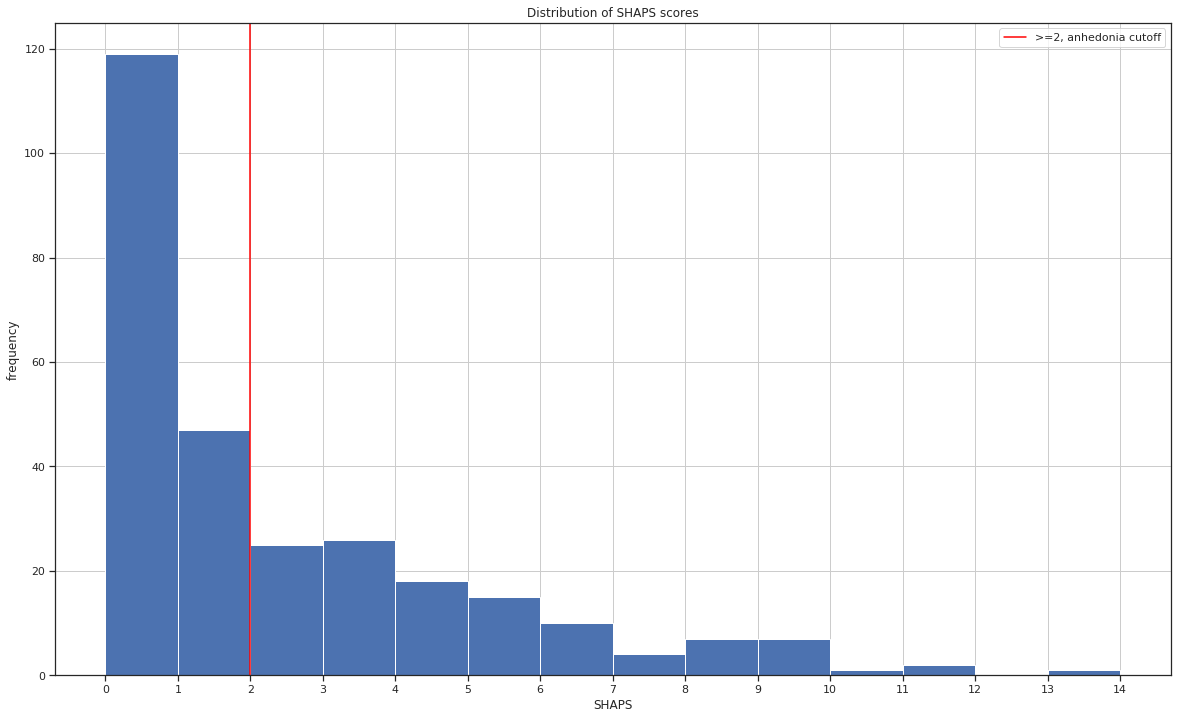

In [58]:
init_df['shaps'].hist(bins=14)
#plt.xlim((0,21))
plt.xticks(np.arange(0,15))
plt.axvline(x=2, color='red', label=">=2, anhedonia cutoff")
plt.xlabel("SHAPS")
plt.ylabel("frequency")
plt.title("Distribution of SHAPS scores")
plt.legend()
plt.show()

In [59]:
init_df['is_anhedonic'] = init_df['shaps'] >= 2

In [60]:
init_df['is_anhedonic'].value_counts()

False    166
True     116
Name: is_anhedonic, dtype: int64

# SHAPS and PHQ Combined loadings

## Imports and Functions

In [62]:
from sklearn.decomposition import PCA
from sklearn import preprocessing

def _ortho_rotation(components, method='varimax', tol=1e-6, max_iter=100):
    """Return rotated components.
    
    https://github.com/scikit-learn/scikit-learn/pull/11064/files
    """
    nrow, ncol = components.shape
    rotation_matrix = np.eye(ncol)
    var = 0

    for _ in range(max_iter):
        comp_rot = np.dot(components, rotation_matrix)
        if method == "varimax":
            tmp = np.diag((comp_rot ** 2).sum(axis=0)) / nrow
            tmp = np.dot(comp_rot, tmp)
        elif method == "quartimax":
            tmp = 0
        u, s, v = np.linalg.svd(
            np.dot(components.T, comp_rot ** 3 - tmp))
        rotation_matrix = np.dot(u, v)
        var_new = np.sum(s)
        if var != 0 and var_new < var * (1 + tol):
            break
        var = var_new

    return np.dot(components, rotation_matrix).T

In [63]:
shaps_cols = baseline_df.columns[baseline_df.columns.str.contains('shaps')][:-1]
shaps_df = baseline_df[shaps_cols]
# 1-2 PNAs in a few questions, replace with 3
shaps_df = shaps_df.replace(to_replace=99, value=3)

In [64]:
shaps_df.describe()

,shaps_01,shaps_02,shaps_03,shaps_04,shaps_05,shaps_06,shaps_07,shaps_08,shaps_09,shaps_10,shaps_11,shaps_12,shaps_13,shaps_14
count,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000
mean,3.464539,3.365248,3.074468,3.326241,3.212766,3.237589,3.088652,3.109929,3.078014,3.361702,3.067376,3.319149,3.343972,3.216312
std,0.608789,0.683771,0.767294,0.685347,0.733621,0.738088,0.732528,0.753620,0.809823,0.661892,0.753922,0.704021,0.663311,0.720332
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
50%,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
75%,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
max,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000


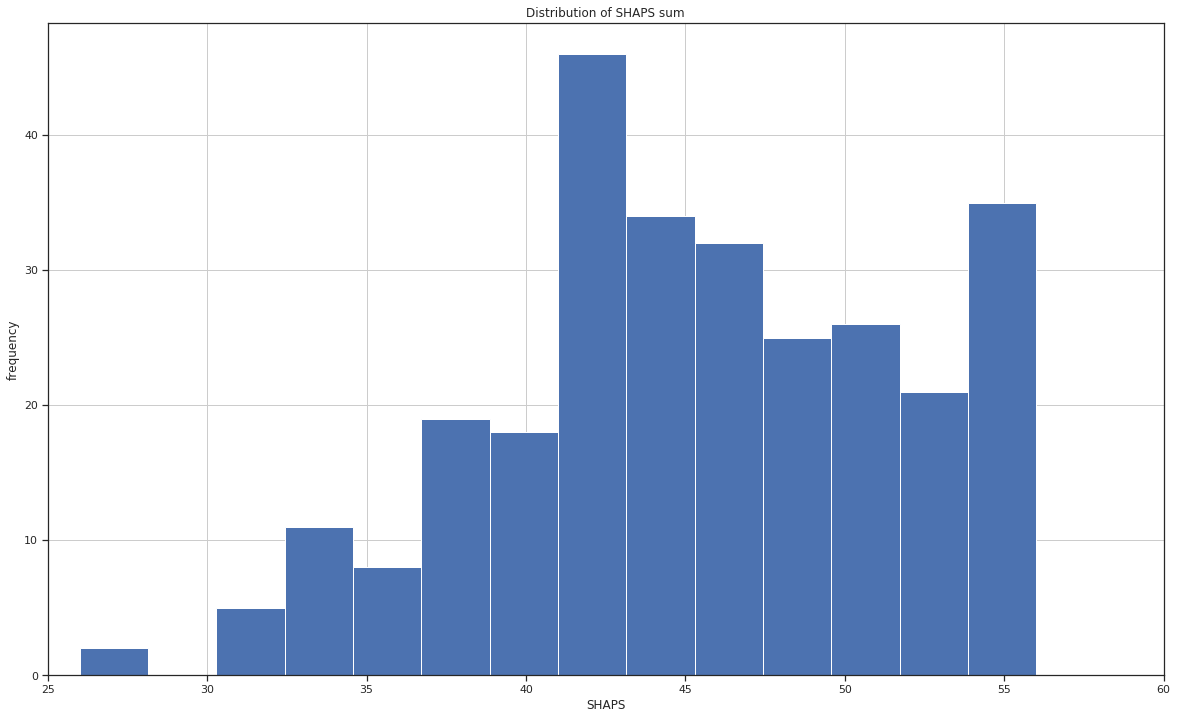

In [65]:
shaps_df.sum(axis=1).hist(bins=14)
plt.xlim((25,60))
plt.xticks(np.arange(25,61,5))
plt.xlabel("SHAPS")
plt.ylabel("frequency")
plt.title("Distribution of SHAPS sum")
plt.show()

In [66]:
init_df['shaps_sum'] = shaps_df.sum(axis=1)

In [67]:
phq_cols = baseline_df.columns[baseline_df.columns.str.contains('phq')]
phq_df = baseline_df[phq_cols]

## SHAPS and PHQ

In [35]:
shaps_phq = pd.concat([phq_df, shaps_df], axis=1)
shaps_phq = shaps_phq.drop(['phq_total_sc', 'phq10_sc'], axis='columns')

In [37]:
shaps_phq_scaled = preprocessing.scale(shaps_phq)
pca_transformer = PCA(n_components=5, random_state=0)
pca_transformed = pca_transformer.fit_transform(shaps_phq_scaled)

In [38]:
var_df = pd.Series(pca_transformer.explained_variance_ratio_).to_frame()
var_df.columns = ['var_explained']
var_df.head()

,var_explained
0,0.369529
1,0.097467
2,0.056317
3,0.047606
4,0.042636


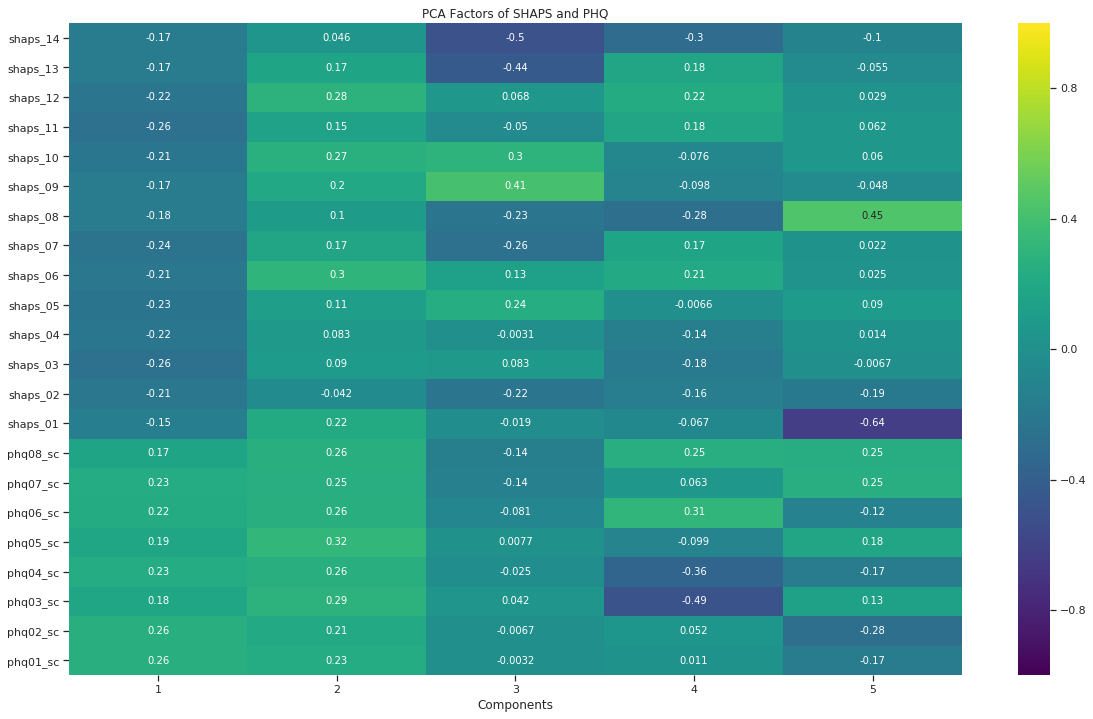

In [44]:
plt.rcParams["figure.figsize"] = [20,12]
sns.heatmap(np.transpose(pca_transformer.components_), annot=True, vmin=-1, vmax=1, cmap="viridis")
plt.ylim(0,22)
plt.xlim(0,5)
plt.yticks(np.arange(0.5,22), shaps_phq.columns.values, rotation='horizontal')
plt.xticks(np.arange(0.5, 5), np.arange(1,6))
plt.xlabel("Components")
plt.title("PCA Factors of SHAPS and PHQ")
plt.show()

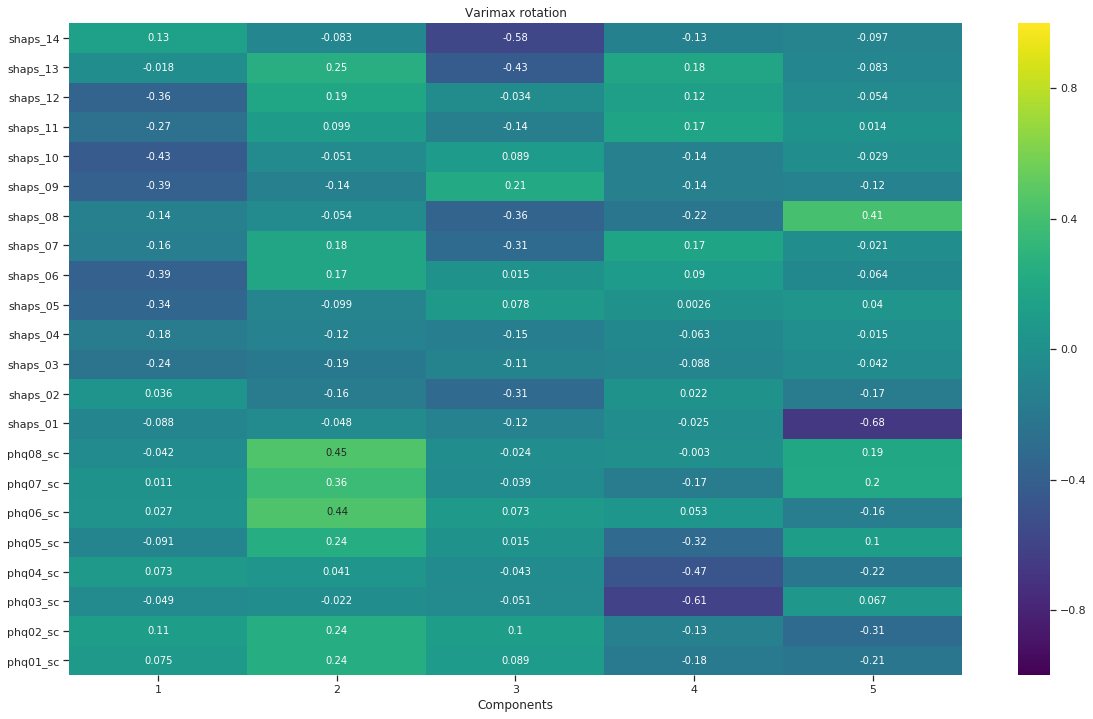

In [45]:
varimax = _ortho_rotation(pca_transformer.components_.T)

plt.rcParams["figure.figsize"] = [20,12]
sns.heatmap(np.transpose(varimax), annot=True, vmin=-1, vmax=1, cmap="viridis")
plt.ylim(0,22)
plt.xlim(0,5)
plt.yticks(np.arange(0.5,22), shaps_phq.columns.values, rotation='horizontal')
plt.xticks(np.arange(0.5, 5), np.arange(1,6))
plt.xlabel("Components")
plt.title("Varimax rotation")
plt.show()

From the Varimax rotation, the following SHAPS questions "load" the most onto the first component:
    - shaps05: I would enjoy a warm bath or refreshing shower
    - shaps06: I would find pleasure in the scent of flowers or the smell of a fresh sea breeze or freshly baked bread
    - shaps09: I would enjoy reading a book, magazine or newspaper
    - shaps10: I would enjoy a cup of tea or coffee or my favorite drink
    - shaps12: I would be able to enjoy a beautiful landscape or view
    
The following PHQ questions "load" the most onto the second component:
    - phq06: 6. Feeling bad about yourself --- or that you are a failure or have let yourself or your family down
    - phq07: 7. Trouble concentrating on things, such as reading the newspaper or watching television
    - phq08: 8. Moving or speaking so slowly that other people could have noticed? Or the opposite --- being so fidgety or restless that you have been moving around a lot more than usual

# EMAs

## Morning

In [68]:
morn_ema_df = pd.DataFrame()
all_ids = wave1_ids

for pid in all_ids:
    morn_df = pd.read_pickle("data_pull/morning_ema/{}.df".format(pid))
    morn_ema_df = morn_ema_df.append(morn_df, sort=True)

In [69]:
morn_ema_df['timestamp'] = morn_ema_df['timestamp'].astype(int)
morn_ema_df['timezone-offset'] = morn_ema_df['timezone-offset'].astype(int)
morn_ema_df['sleep-quality'] = morn_ema_df['sleep-quality'].astype(int)
morn_ema_df['mood'] = morn_ema_df['mood'].astype(int)

morn_ema_df['adj_ts'] = morn_ema_df['timestamp'] + morn_ema_df['timezone-offset']
morn_ema_df['date'] = pd.to_datetime(morn_ema_df['adj_ts'], unit='s').dt.floor('d')
morn_ema_df['pid'] = morn_ema_df['source']

In [70]:
morn_ema_cols = ['mood', 'sleep-quality', 'pid', 'date']
morn_emas = morn_ema_df[morn_ema_cols]

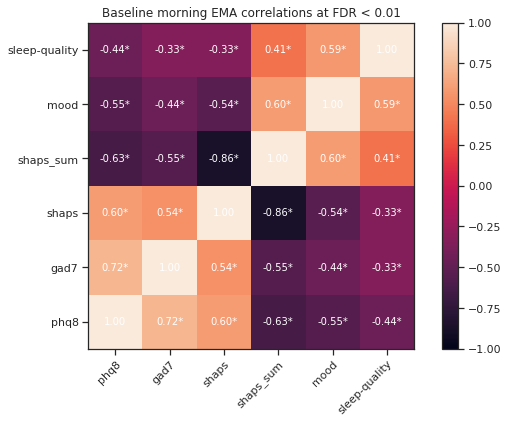

In [72]:
init_cols = ['phq8', 'gad7', 'shaps', 'shaps_sum']
init_df['pid'] = init_df['pid'].astype(str)
corr_df = init_df[init_cols + ['pid']].copy()
corr_df = corr_df.merge(morn_emas.groupby('pid').mean().reset_index(), on='pid', how='left')
corr_df = corr_df.dropna()
corr_df = corr_df.drop(['pid'], axis='columns')
corrs, _, p_vals = run_r_corr(corr_df)
plt = build_corr_mat(corrs, p_vals, corr_df.columns.values, 'Baseline morning EMA correlations at FDR < 0.01', 0.01, figsize=[10,6])
plt.show()

## Evening 

In [73]:
even_ema_df = pd.DataFrame()

for pid in wave1_ids:
    even_df = pd.read_pickle("data_pull/evening_ema/{}.df".format(pid))
    even_ema_df = even_ema_df.append(even_df, sort=True)

In [74]:
even_ema_df['timestamp'] = even_ema_df['timestamp'].astype(int)
even_ema_df['timezone-offset'] = even_ema_df['timezone-offset'].astype(int)

even_ema_df['adj_ts'] = even_ema_df['timestamp'] + even_ema_df['timezone-offset']
even_ema_df['date'] = pd.to_datetime(even_ema_df['adj_ts'], unit='s').dt.floor('d')
even_ema_df['pid'] = even_ema_df['source']

In [75]:
even_ema_df['timestamp'] = even_ema_df['timestamp'].astype(int)
even_ema_df['timezone-offset'] = even_ema_df['timezone-offset'].astype(int)

even_ema_df['adj_ts'] = even_ema_df['timestamp'] + even_ema_df['timezone-offset']
even_ema_df['date'] = pd.to_datetime(even_ema_df['adj_ts'], unit='s').dt.floor('d')
even_ema_df['pid'] = even_ema_df['source']
# adjust for yesterday surveys
even_ema_df['for_yesterday'] = even_ema_df['for_yesterday'].fillna(0)
even_ema_df['for_yesterday'] = even_ema_df['for_yesterday'].astype(int)
even_ema_df['adj_date'] = even_ema_df['date'] - pd.to_timedelta(even_ema_df['for_yesterday'], unit='D')

even_ema_df['mood'] = even_ema_df['mood'].astype(int)

In [76]:
even_ema_cols = ['mood', 'pid', 'date']
even_emas = even_ema_df[even_ema_cols]

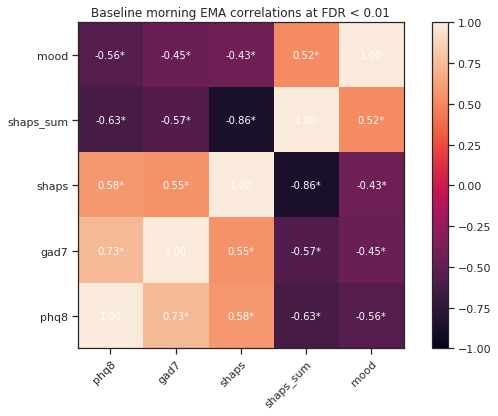

In [77]:
init_cols = ['phq8', 'gad7', 'shaps', 'shaps_sum']
init_df['pid'] = init_df['pid'].astype(str)
corr_df = init_df[init_cols + ['pid']].copy()
corr_df = corr_df.merge(even_emas.groupby('pid').mean().reset_index(), on='pid', how='left')
corr_df = corr_df.dropna()
corr_df = corr_df.drop(['pid'], axis='columns')
corrs, _, p_vals = run_r_corr(corr_df)
plt = build_corr_mat(corrs, p_vals, corr_df.columns.values, 'Baseline morning EMA correlations at FDR < 0.01', 0.01, figsize=[10,6])
plt.show()

In [78]:
ema_df = morn_emas.copy()
ema_df = ema_df.rename({'mood': 'morn_mood'}, axis='columns')
ema_df = ema_df.merge(even_emas, on=['pid', 'date'], how='left')
ema_df = ema_df.rename({'mood': 'even_mood'}, axis='columns')

# Daily State Statistics

## Load data

In [88]:
all_fga = pd.read_pickle("ls_data/all_fga.df")
all_scr = pd.read_pickle("ls_data/all_scr.df")
all_cal = pd.read_pickle("ls_data/all_cal.df")
all_sms = pd.read_pickle("ls_data/all_sms.df")
all_fus = pd.read_pickle("ls_data/all_fus.df")

all_sloc_df = pd.read_pickle("ls_data/all_sloc.df")
sloc_hr_all = pd.read_pickle("ls_data/all_sloc_hr.df")

## Foreground application and screen time

In [89]:
apps = [
    'katana',
    'orca', 
    'messaging',
    'launcher',
    'chrome',
    'email',
    'instagram',
    'youtube',
    'maps',
    'snapchat',
    'browser'
]

In [90]:
all_fga.head()

,hr,katana,orca,messaging,launcher,chrome,email,instagram,youtube,maps,snapchat,browser,pid
0,2019-07-27 12:00:00,1771.0,0.0,0.0,105.0,0.0,0.0,405.0,0.0,0.0,0.0,0.0,08343773
1,2019-07-27 13:00:00,1336.0,0.0,0.0,255.0,315.0,0.0,195.0,0.0,0.0,0.0,0.0,08343773
2,2019-07-27 14:00:00,1666.0,0.0,0.0,180.0,0.0,0.0,330.0,0.0,0.0,0.0,0.0,08343773
3,2019-07-27 15:00:00,1997.0,0.0,0.0,309.0,165.0,0.0,195.0,0.0,60.0,0.0,0.0,08343773
4,2019-07-27 16:00:00,1289.0,0.0,0.0,379.0,0.0,0.0,75.0,0.0,0.0,0.0,0.0,08343773


In [91]:
all_fga[apps] = all_fga[apps].clip(lower=0)
all_fga['date'] = all_fga['hr'].dt.floor('d')

In [92]:
fga_daily = all_fga.groupby(['pid', 'date']).sum()
fga_daily = fga_daily.reset_index()

In [93]:
fga_daily = fga_daily.loc[(fga_daily['date'] >= ema_df['date'].min()) & (fga_daily['date'] <= ema_df['date'].max())]

In [94]:
all_scr['date'] = all_scr['hr'].dt.floor('d')
scr_daily = all_scr.groupby(['pid', 'date']).sum()
scr_daily = scr_daily.reset_index()
scr_daily = scr_daily.loc[(scr_daily['date'] >= ema_df['date'].min()) & (scr_daily['date'] <= ema_df['date'].max())]

In [95]:
fga_daily = fga_daily.merge(scr_daily, on=['pid', 'date'], how='left')

In [96]:
fga_daily["is_wkday"] = (pd.to_datetime(fga_daily['date']).dt.dayofweek < 5).astype(float)
fga_daily.describe()
#fga_daily = fga_daily.loc[fga_daily['katana'] > 0]

,katana,orca,messaging,launcher,chrome,email,instagram,youtube,maps,snapchat,browser,duration,transitions,is_wkday
count,2481.000000,2481.000000,2481.000000,2481.000000,2481.000000,2481.000000,2481.000000,2481.000000,2481.000000,2481.000000,2481.000000,2447.000000,2447.000000,2481.000000
mean,1489.510278,226.259573,971.986296,2376.240629,1871.143894,47.241032,473.198307,935.700121,401.341798,97.198307,181.079000,14577.312628,124.539845,0.777106
std,2750.171919,925.241463,1670.616262,3742.905887,3431.833793,218.649965,1192.350768,3762.190967,1331.964920,419.193661,776.265363,8725.950613,106.323662,0.416272
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,534.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8081.500000,51.000000,1.000000
50%,30.000000,0.000000,245.000000,1300.000000,631.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13962.000000,97.000000,1.000000
75%,1865.000000,60.000000,1219.000000,2831.000000,2232.000000,0.000000,216.000000,60.000000,105.000000,0.000000,0.000000,20331.000000,166.000000,1.000000
max,20526.000000,14697.000000,19975.000000,58938.000000,40185.000000,3947.000000,15024.000000,58634.000000,21205.000000,5759.000000,15499.000000,52721.000000,853.000000,1.000000


In [97]:
fga_daily.to_pickle("ls_data/fga_daily.df")

### Correlations

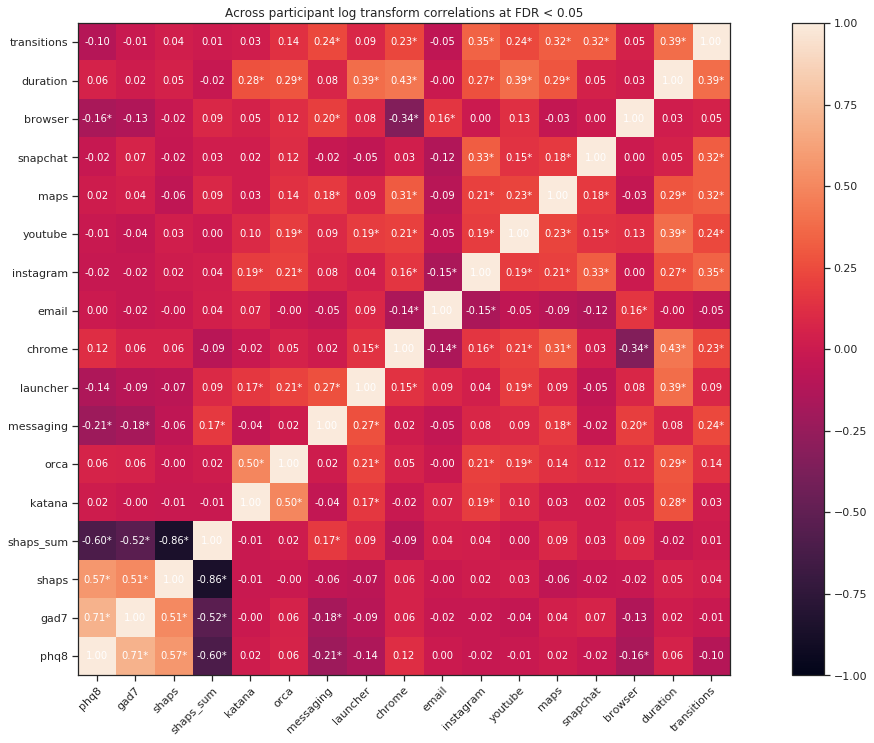

In [98]:
fga_mean = fga_daily.groupby('pid').mean()
fga_mean = np.log(fga_mean + 1)
init_cols = ['phq8', 'gad7', 'shaps', 'shaps_sum']
corr_df = init_df[init_cols + ['pid']].copy()
corr_df['gad7'] = corr_df['gad7'].clip(upper=21)
corr_df = corr_df.merge(fga_mean, on='pid', how='left')
corr_df = corr_df.dropna()
corr_df = corr_df.drop(['pid', 'is_wkday'], axis='columns')
corrs, _, p_vals = run_r_corr(corr_df)
plt = build_corr_mat(corrs, p_vals, corr_df.columns.values, 'Across participant log transform correlations at FDR < 0.05', 0.05, figsize=[22,12])
plt.show()

### Partial correlations controlling for PHQ8

#### All days of week

In [101]:
# all days of week
build_partial_corr(corr_df, 'shaps', 'phq8')

,X,Y,covar,r_ctl,p_ctl,r_unctl,p_unctl
0,shaps,transitions,['phq8'],0.125,0.03894,0.065,0.284035


#### Weekdays

In [102]:
# weekdays

fga_wkday = fga_daily.loc[fga_daily['is_wkday'] == 1]
fga_mean_wkday = fga_wkday.groupby('pid').mean()
fga_mean_wkday = np.log(fga_mean_wkday + 1)
init_cols = ['phq8', 'gad7', 'shaps', 'shaps_sum']
corr_df = init_df[init_cols + ['pid']].copy()
corr_df = corr_df.merge(fga_mean_wkday, on='pid', how='left')
corr_df = corr_df.dropna()
corr_df = corr_df.drop(['pid'], axis='columns')

build_partial_corr(corr_df, 'shaps', 'phq8')

,X,Y,covar,r_ctl,p_ctl,r_unctl,p_unctl
0,shaps,transitions,['phq8'],0.136,0.024175,0.074,0.222077


#### Weekends

In [103]:
# weekends
fga_wkend = fga_daily.loc[fga_daily['is_wkday'] == 0]
fga_mean_wkend = fga_wkend.groupby('pid').mean()
fga_mean_wkend = np.log(fga_mean_wkend + 1)
init_cols = ['phq8', 'gad7', 'shaps', 'shaps_sum']
corr_df = init_df[init_cols + ['pid']].copy()
corr_df = corr_df.merge(fga_mean_wkend, on='pid', how='left')
corr_df = corr_df.dropna()
corr_df = corr_df.drop(['pid'], axis='columns')

build_partial_corr(corr_df, 'shaps', 'phq8')

,X,Y,covar,r_ctl,p_ctl,r_unctl,p_unctl
0,shaps_sum,maps,['phq8'],0.13,0.032265,0.188,0.001821


## Call and text

In [104]:
baseline_df['routine_slabels09'].value_counts()

1    226
2     56
Name: routine_slabels09, dtype: int64

In [105]:
all_cal['date'] = all_cal['call_hour'].dt.floor('d')
cal_daily = all_cal.groupby(['pid', 'date']).sum()
cal_daily = cal_daily.reset_index()
cal_daily = cal_daily.loc[(cal_daily['date'] >= ema_df['date'].min()) & (cal_daily['date'] <= ema_df['date'].max())]

In [106]:
all_sms['date'] = all_sms['hour'].dt.floor('d')
sms_daily = all_sms.groupby(['pid', 'date']).sum()
sms_daily = sms_daily.reset_index()
sms_daily = sms_daily.loc[(sms_daily['date'] >= ema_df['date'].min()) & (sms_daily['date'] <= ema_df['date'].max())]

In [107]:
#comm_daily = scr_daily.merge(cal_daily, on=['pid', 'date'], how='left')
comm_daily = cal_daily.merge(sms_daily, on=['pid', 'date'], how='left')

comm_daily["is_wkday"] = (pd.to_datetime(comm_daily['date']).dt.dayofweek < 5).astype(float)

comm_mean = comm_daily.groupby('pid').mean()
comm_mean = np.log(comm_mean + 1)


### Texting Response Time

In [108]:
sms_response = pd.read_pickle("ls_data/response_sms.df")

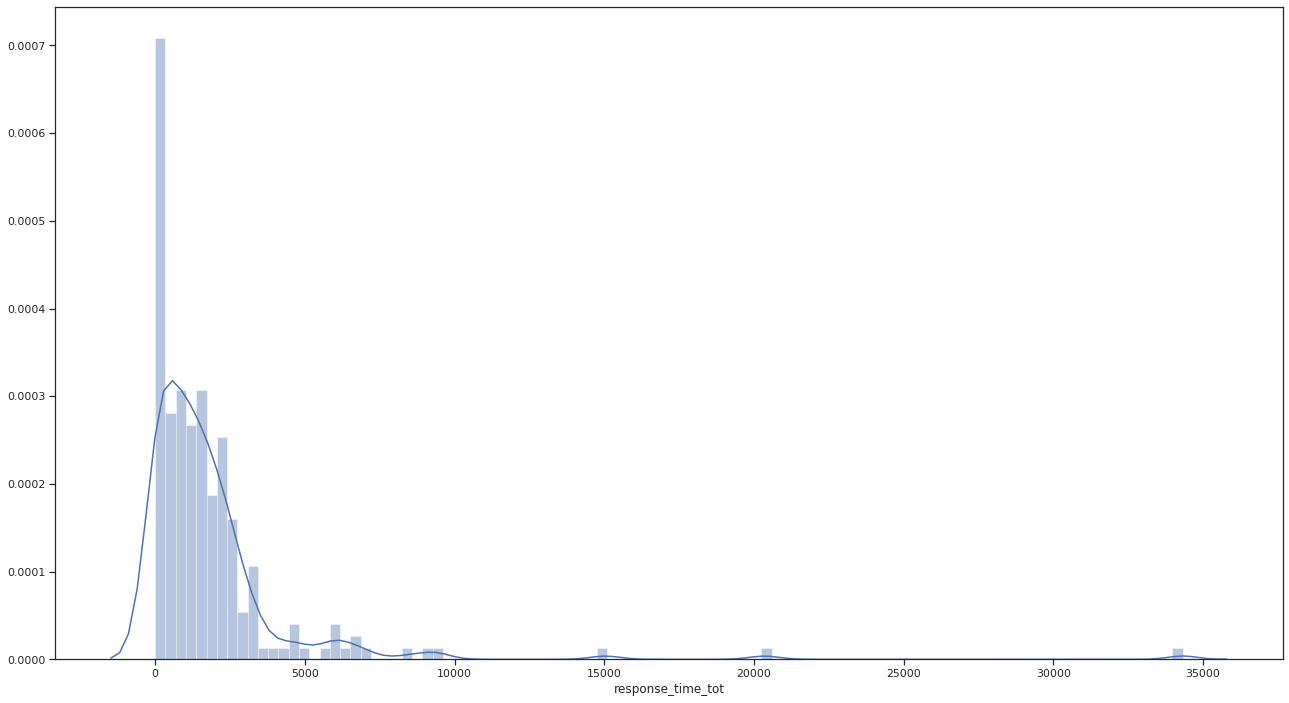

In [109]:
sns.distplot(sms_response.loc[~sms_response['response_time_tot'].isna()]['response_time_tot'], bins=100)

In [110]:
sms_response['response_time_tot'] = np.log(sms_response['response_time_tot'] + 1)
sms_response['response_time_wkday'] = np.log(sms_response['response_time_wkday'] + 1)
sms_response['response_time_wkend'] = np.log(sms_response['response_time_wkend'] + 1)


In [111]:
sms_response.head()

,pid,response_time_tot,response_time_wkday,response_time_wkend,unique_contacts
0,08343773,3.433987,0.000000,4.110874,13
0,18583649,7.288210,7.484380,5.271289,18
0,99050875,5.756533,5.756533,NaN,126
0,31456993,NaN,NaN,NaN,18
0,01495950,NaN,NaN,NaN,14


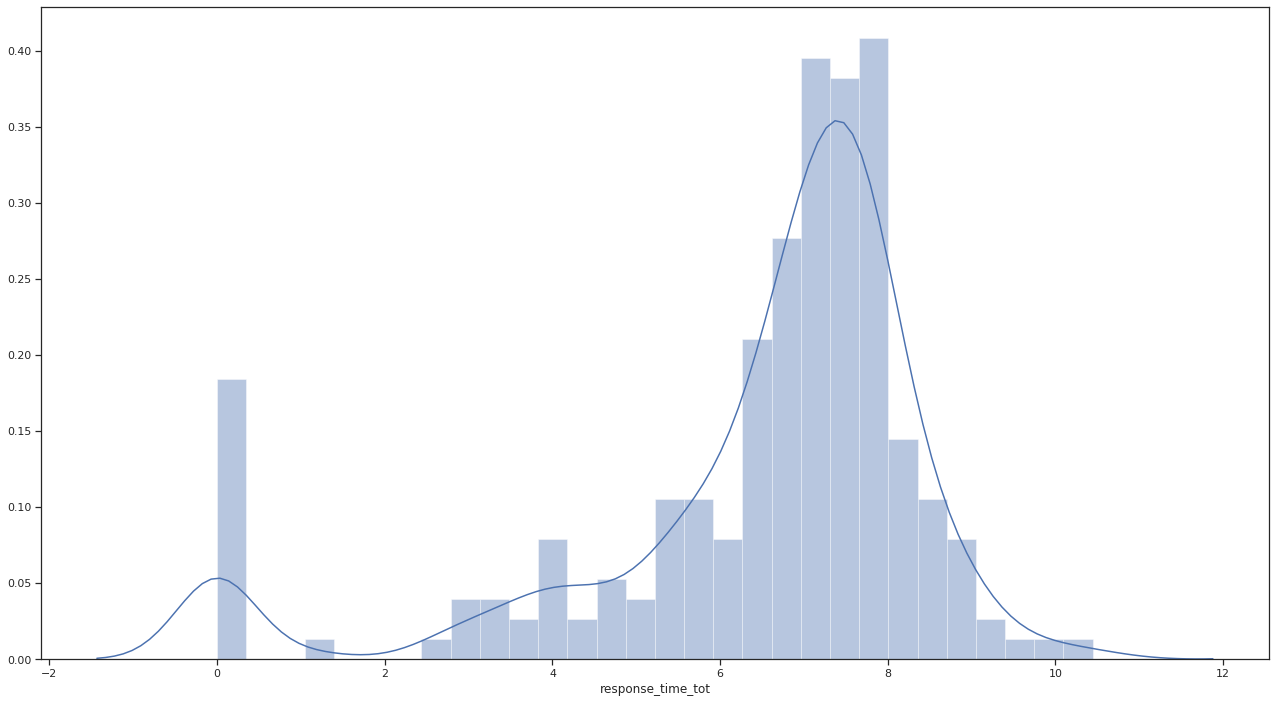

In [112]:
sns.distplot(sms_response.loc[~sms_response['response_time_tot'].isna()]['response_time_tot'], bins=30)
plt.show()

(156, 16)


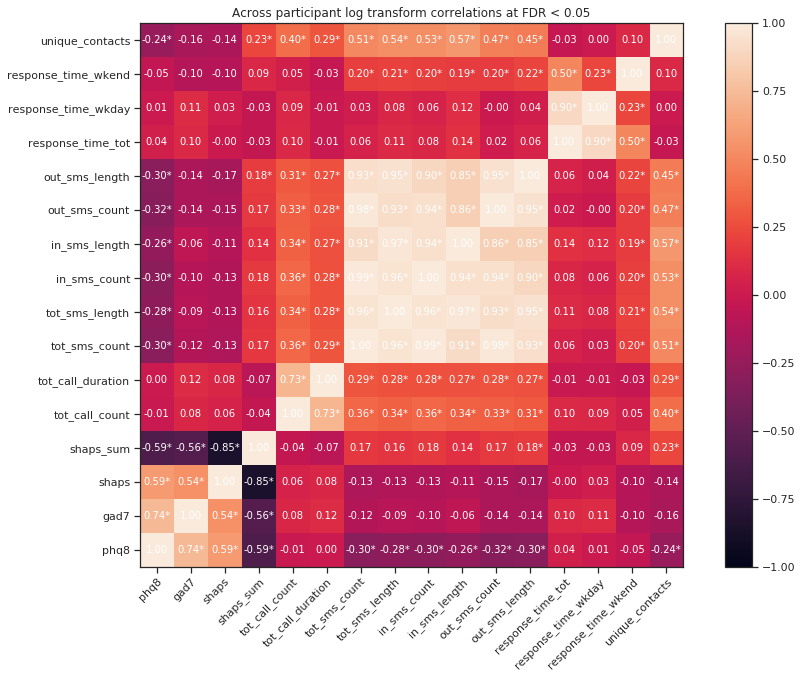

In [115]:
#init_cols = ['phq8', 'gad7', 'shaps', 'spin', 'dx_depression', 'dx_ptsd', 'dx_substance']
corr_df = init_df[init_cols + ['pid']].copy()
corr_df = corr_df.merge(comm_mean, on='pid', how='left')
corr_df = corr_df.merge(sms_response, on='pid', how='left')
corr_df = corr_df.dropna()
corr_df = corr_df.drop(['pid', 'is_wkday'], axis='columns')
print(corr_df.shape)
corrs, _, p_vals = run_r_corr(corr_df)
plt = build_corr_mat(corrs, p_vals, corr_df.columns.values, 'Across participant log transform correlations at FDR < 0.05', 0.05, figsize=[15,10])
plt.xlim(-0.5,corr_df.shape[1] - 0.5)
plt.ylim(-0.5,corr_df.shape[1] - 0.5)
plt.show()

### Partial correlations controlling for PHQ8

#### All Days

In [116]:
# all days
build_partial_corr(corr_df, 'shaps', 'phq8')

,covar,r_ctl,p_ctl,X,Y,r_unctl,p_unctl


#### Weekdays

In [117]:
# weekdays
comm_wkday = comm_daily.loc[comm_daily['is_wkday'] == 1]
comm_mean_wkday = comm_wkday.groupby('pid').mean()
comm_mean_wkday = np.log(comm_mean_wkday + 1)

corr_df = init_df[init_cols + ['pid']].copy()
corr_df = corr_df.merge(comm_mean_wkday, on='pid', how='left')
corr_df = corr_df.dropna()
corr_df = corr_df.drop(['pid'], axis='columns')

build_partial_corr(corr_df, 'shaps', 'phq8')

,covar,r_ctl,p_ctl,X,Y,r_unctl,p_unctl


#### Weekends

In [118]:
# weekdays
comm_wkend = comm_daily.loc[comm_daily['is_wkday'] == 0]
comm_mean_wkend = comm_wkend.groupby('pid').mean()
comm_mean_wkend = np.log(comm_mean_wkend + 1)

corr_df = init_df[init_cols + ['pid']].copy()
corr_df = corr_df.merge(comm_mean_wkend, on='pid', how='left')
corr_df = corr_df.dropna()
corr_df = corr_df.drop(['pid'], axis='columns')

build_partial_corr(corr_df, 'shaps', 'phq8')

,covar,r_ctl,p_ctl,X,Y,r_unctl,p_unctl


## Fused Location

In [119]:
fus_daily = all_fus.loc[(all_fus['date'] >= ema_df['date'].min()) & (all_fus['date'] <= ema_df['date'].max())]

fus_daily['norm_entropy'] = fus_daily['entropy'] / np.log(fus_daily['cluster'] + 1)
fus_daily["is_wkday"] = (pd.to_datetime(fus_daily['date']).dt.dayofweek < 5).astype(float)

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


### Circadian Movement

In [122]:
circ_df = pd.read_pickle("ls_data/circ_movt.df")

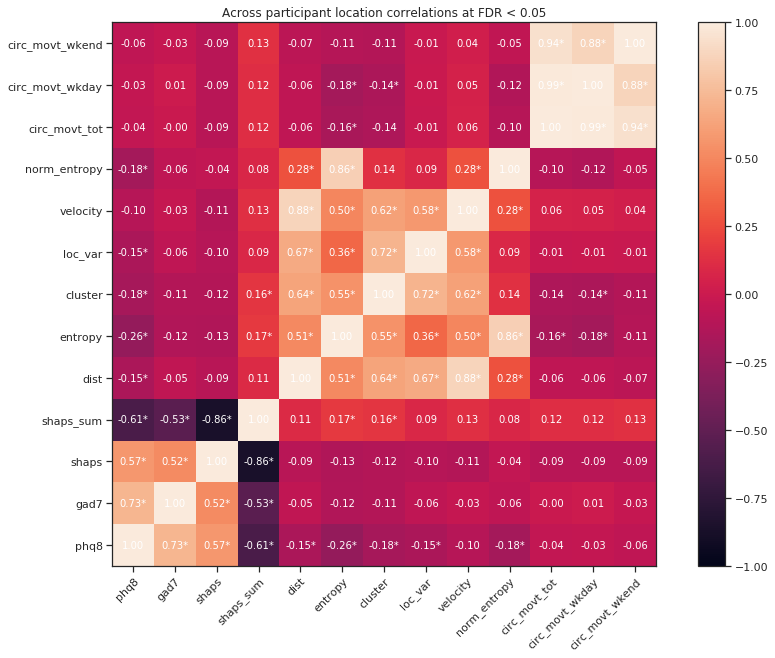

In [123]:
fus_mean = fus_daily.groupby('pid').mean()

corr_df = init_df[init_cols + ['pid']].copy()
corr_df = corr_df.merge(fus_mean, on='pid', how='left')
corr_df = corr_df.merge(circ_df, on='pid', how='left')
corr_df = corr_df.replace([np.inf, -np.inf], np.nan)
corr_df = corr_df.dropna()
corr_df = corr_df.drop(['pid', 'is_wkday'], axis='columns')
corrs, _, p_vals = run_r_corr(corr_df)

plt = build_corr_mat(corrs, p_vals, corr_df.columns.values, 'Across participant location correlations at FDR < 0.05', 0.05, figsize=[15,10])
plt.ylim(-0.5, corr_df.shape[1]-0.5)
plt.xlim(-0.5, corr_df.shape[1]-0.5)
plt.show()

### Partial Correlations controlling for PHQ8

#### All days

In [124]:
build_partial_corr(corr_df, 'shaps', 'phq8')

,X,Y,covar,r_ctl,p_ctl,r_unctl,p_unctl
0,shaps_sum,circ_movt_tot,['phq8'],0.129,0.034843,0.125,0.041184


#### Weekday

In [125]:
fus_wkday = fus_daily[fus_daily['is_wkday'] == 1]
fus_mean_wkday = fus_wkday.groupby('pid').mean()

corr_df = init_df[init_cols + ['pid']].copy()
corr_df = corr_df.merge(fus_mean_wkday, on='pid', how='left')
corr_df = corr_df.replace([np.inf, -np.inf], np.nan)
corr_df = corr_df.dropna()
corr_df = corr_df.drop(['pid'], axis='columns')

build_partial_corr(corr_df, 'shaps', 'phq8')

,covar,r_ctl,p_ctl,X,Y,r_unctl,p_unctl


#### Weekend

In [126]:
fus_wkend = fus_daily[fus_daily['is_wkday'] == 0]
fus_mean_wkend = fus_wkend.groupby('pid').mean()

corr_df = init_df[init_cols + ['pid']].copy()
corr_df = corr_df.merge(fus_mean_wkend, on='pid', how='left')
corr_df = corr_df.replace([np.inf, -np.inf], np.nan)
corr_df = corr_df.dropna()
corr_df = corr_df.drop(['pid'], axis='columns')

build_partial_corr(corr_df, 'shaps', 'phq8')

,covar,r_ctl,p_ctl,X,Y,r_unctl,p_unctl


## Semantic Location Duration

In [127]:
dur_cols = list(sloc_hr_all.columns[sloc_hr_all.columns.str.contains("dur")].values)
dur_cols = ['pid', 'hr'] + dur_cols
sloc_dur_df = sloc_hr_all[dur_cols]
sloc_dur_df['date'] = sloc_dur_df['hr'].dt.floor('D')

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [128]:
sloc_dur_df = sloc_dur_df.loc[(sloc_dur_df['date'] >= ema_df['date'].min()) & (sloc_dur_df['date'] <= ema_df['date'].max())]

sloc_dur_df["is_wkday"] = (pd.to_datetime(sloc_dur_df['date']).dt.dayofweek < 5).astype(float)
mean_dur_df = sloc_dur_df.groupby(['pid', 'date'], as_index=False).sum()
mean_dur_df = mean_dur_df.groupby('pid', as_index=False).mean()

In [130]:
shaps_dur = init_df[init_cols + ['pid']]
shaps_dur = shaps_dur.merge(mean_dur_df, on='pid', how='left')

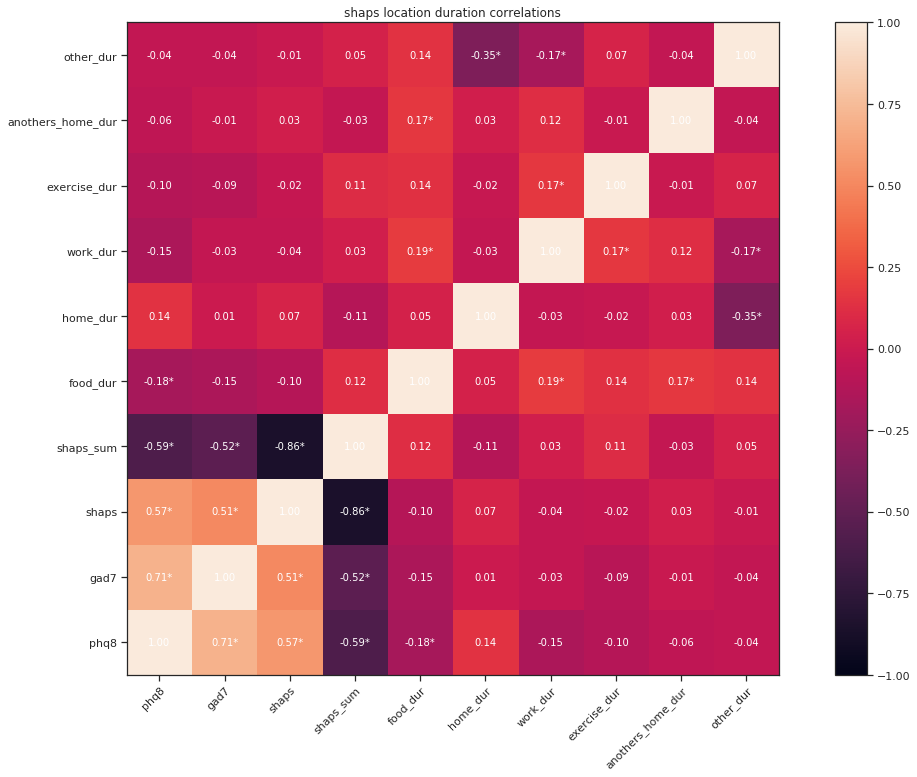

In [133]:
corr_df = shaps_dur.copy()
corr_df = corr_df.dropna()
corr_df[dur_cols[2:]] = np.log(corr_df[dur_cols[2:]] + 1)

corr_df = corr_df.drop(['pid', 'religion_dur', 'travel_dur', 'is_wkday'], axis='columns')
corrs, _, p_vals = run_r_corr(corr_df)
plt = build_corr_mat(corrs, p_vals, corr_df.columns.values, 'shaps location duration correlations', 0.05, figsize=[20,12])
plt.show()

### Partial Correlations controlling for PHQ8

#### All days

In [134]:
build_partial_corr(corr_df, 'shaps', 'phq8')

,covar,r_ctl,p_ctl,X,Y,r_unctl,p_unctl


#### Weekdays

In [135]:
sloc_dur_wkday = sloc_dur_df.loc[sloc_dur_df['is_wkday'] == 1]
mean_dur_wkday = sloc_dur_wkday.groupby(['pid', 'date'], as_index=False).sum()
mean_dur_wkday = mean_dur_wkday.groupby('pid', as_index=False).mean()

shaps_dur = init_df[['pid'] + init_cols]
shaps_dur = shaps_dur.merge(mean_dur_wkday, on='pid', how='left')
corr_df = shaps_dur.copy()
corr_df = corr_df.dropna()
corr_df[dur_cols[2:]] = np.log(corr_df[dur_cols[2:]] + 1)

corr_df = corr_df.drop(['is_wkday'], axis='columns')

#corr_df = corr_df.drop(['pid', 'religion_dur', 'travel_dur'], axis='columns')

build_partial_corr(corr_df, 'shaps', 'phq8')

,covar,r_ctl,p_ctl,X,Y,r_unctl,p_unctl


#### Weekends

In [138]:
sloc_dur_wkend = sloc_dur_df.loc[sloc_dur_df['is_wkday'] == 0]
mean_dur_wkend = sloc_dur_wkend.groupby(['pid', 'date'], as_index=False).sum()
mean_dur_wkend = mean_dur_wkend.groupby('pid', as_index=False).mean()

shaps_dur = init_df[['pid'] + init_cols]
shaps_dur = shaps_dur.merge(mean_dur_wkend, on='pid', how='left')
corr_df = shaps_dur.copy()
corr_df = corr_df.dropna()
corr_df[dur_cols[2:]] = np.log(corr_df[dur_cols[2:]] + 1)

#corr_df = corr_df.drop(['pid', 'religion_dur', 'travel_dur'], axis='columns')

build_partial_corr(corr_df, 'shaps', 'phq8')

,covar,r_ctl,p_ctl,X,Y,r_unctl,p_unctl


## Semantic Location Transitions

In [139]:
trans_cols = list(sloc_hr_all.columns[~sloc_hr_all.columns.str.contains("dur")].values)
sloc_trans_df = sloc_hr_all[trans_cols]
sloc_trans_df['date'] = sloc_trans_df['hr'].dt.floor('D')

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [140]:
sloc_trans_df = sloc_trans_df.loc[(sloc_trans_df['date'] >= ema_df['date'].min()) & (sloc_trans_df['date'] <= ema_df['date'].max())]
sloc_trans_df["is_wkday"] = (pd.to_datetime(sloc_trans_df['date']).dt.dayofweek < 5).astype(float)

mean_trans_df = sloc_trans_df.groupby(['pid', 'date'], as_index=False).sum()
mean_trans_df = mean_trans_df.groupby('pid', as_index=False).mean()

In [141]:
mean_trans_df.describe()

,food_home,food_work,food_exercise,food_anothers_home,food_religion,food_travel,food_other,home_food,home_work,home_exercise,...,travel_other,other_food,other_home,other_work,other_exercise,other_anothers_home,other_religion,other_travel,tot_tansitions,is_wkday
count,274.000000,274.000000,274.000000,274.000000,274.0,274.0,274.000000,274.000000,274.000000,274.000000,...,274.0,274.000000,274.000000,274.000000,274.000000,274.000000,274.0,274.0,274.000000,274.000000
mean,0.043390,0.019515,0.002028,0.009327,0.0,0.0,0.167547,0.037307,0.047851,0.012672,...,0.0,0.166462,1.084977,0.472972,0.056012,0.147600,0.0,0.0,4.219663,18.522649
std,0.126385,0.077207,0.014899,0.057484,0.0,0.0,0.272625,0.116691,0.217198,0.069398,...,0.0,0.262965,1.256928,0.674561,0.185710,0.436520,0.0,0.0,3.790604,0.888234
min,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,9.750000
25%,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.444444,0.000000,0.000000,0.000000,0.0,0.0,1.888889,18.666667
50%,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.888889,0.277778,0.000000,0.000000,0.0,0.0,3.666667,18.666667
75%,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.222222,0.000000,0.000000,0.000000,...,0.0,0.222222,1.333333,0.729167,0.000000,0.111111,0.0,0.0,5.666667,18.666667
max,0.777778,0.666667,0.111111,0.666667,0.0,0.0,1.444444,1.000000,2.555556,0.666667,...,0.0,1.222222,11.777778,5.333333,1.666667,5.555556,0.0,0.0,30.444444,23.000000


In [144]:
shaps_trans = init_df[['pid'] + init_cols]
#shaps_trans[shaps_cols] = shaps_df[shaps_cols]
shaps_trans = shaps_trans.merge(mean_trans_df, on='pid', how='left')

### Partial Correlations Correcting for PHQ8

#### All days

In [145]:
corr_df = shaps_trans.copy()
corr_df = corr_df.dropna()
corr_df[trans_cols[1:-1]] = np.log(corr_df[trans_cols[1:-1]] + 1)
corr_df = corr_df.drop(['pid'], axis='columns')

build_partial_corr(corr_df, 'shaps', 'phq8')

,X,Y,covar,r_ctl,p_ctl,r_unctl,p_unctl
0,shaps_sum,home_food,['phq8'],-0.132,0.029770,-0.126,0.038101
1,shaps_sum,home_anothers_home,['phq8'],-0.124,0.039939,-0.120,0.047811


#### Weekdays

In [146]:
sloc_trans_wkday = sloc_trans_df.loc[sloc_trans_df['is_wkday'] == 1]
mean_trans_wkday = sloc_trans_wkday.groupby(['pid', 'date'], as_index=False).sum()
mean_trans_wkday = mean_trans_wkday.groupby('pid', as_index=False).mean()

shaps_trans = init_df[['pid'] + init_cols]
#shaps_trans[shaps_cols] = shaps_df[shaps_cols]
shaps_trans = shaps_trans.merge(mean_trans_wkday, on='pid', how='left')

corr_df = shaps_trans.copy()
corr_df = corr_df.dropna()
corr_df[trans_cols[1:-1]] = np.log(corr_df[trans_cols[1:-1]] + 1)
corr_df = corr_df.drop(['pid', 'is_wkday'], axis='columns')

build_partial_corr(corr_df, 'shaps', 'phq8')

,X,Y,covar,r_ctl,p_ctl,r_unctl,p_unctl
0,shaps,food_other,['phq8'],0.128,0.035195,0.072,0.238816
1,shaps,home_food,['phq8'],0.134,0.026895,0.128,0.034784
2,shaps_sum,home_food,['phq8'],-0.158,0.009043,-0.143,0.018440
3,shaps_sum,home_anothers_home,['phq8'],-0.147,0.014784,-0.146,0.016131


#### Weekends

In [150]:
sloc_trans_wkend = sloc_trans_df.loc[sloc_trans_df['is_wkday'] == 0]
mean_trans_wkend = sloc_trans_wkend.groupby(['pid', 'date'], as_index=False).sum()
mean_trans_wkend = mean_trans_wkend.groupby('pid', as_index=False).mean()

shaps_trans = init_df[['pid'] + init_cols]
#shaps_trans[shaps_cols] = shaps_df[shaps_cols]
shaps_trans = shaps_trans.merge(mean_trans_wkend, on='pid', how='left')

corr_df = shaps_trans.copy()
corr_df = corr_df.dropna()
corr_df[trans_cols[1:-1]] = np.log(corr_df[trans_cols[1:-1]] + 1)
corr_df = corr_df.drop(['pid', 'is_wkday'], axis='columns')

build_partial_corr(corr_df, 'shaps', 'phq8')

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/pingouin/pairwise.py:1097: RuntimeWarning: divide by zero encountered in arctanh
  stats['z'] = np.round(np.arctanh(stats['r'].values), 3)


,covar,r_ctl,p_ctl,X,Y,r_unctl,p_unctl
